# 多模型结果可视化

> 需要修改网络结果的路径

In [1]:
import os
import copy
import nibabel as nib
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap, BoundaryNorm
import tracemalloc

# 配置Jupyter友好显示

%matplotlib inline
plt.ioff()  # 关闭交互模式避免重复绘图

In [2]:
def trans_from_wins_to_linux(path):
        path = path.replace('D:', '/mnt/d')
        path = path.replace('\\', '/')
        return path

In [3]:
# BSAE_MODEL_CONFIG  = {
#     # "UNet3D":                       trans_from_wins_to_linux(r"D:\results\outputs\UNet3D_20250330120052"),
#     # "AttnUNet":                     trans_from_wins_to_linux(r"D:\results\outputs\AttUNet3D_20250330121401"),
#     "ResUNet3D_M":                  trans_from_wins_to_linux(r"D:\results\outputs\ResUNet3D_M_20250330123050"),
#     "ResUNet_M_DCLA":               trans_from_wins_to_linux(r"D:\results\outputs\ResUNet_M_DCLA_20250330125151"),
#     # TODO: 添加更多网络
#     # "Mamba3d": trans_from_wins_to_linux(r"D:\results\compared_nets\Mamba3d\Mamba3d_20250314172525")
# }

SOTA_MODELS_CONFIG = {
    "UNet3D": trans_from_wins_to_linux(r"D:\results\1_对比网络结果\output\UNet3D_20250528111955"),
    "AttnUNet": trans_from_wins_to_linux(r"D:\results\1_对比网络结果\output\AttUNet3D_20250528112832"),
    "DCLA_UNet": trans_from_wins_to_linux(r"D:\results\2_消融实验结果\【v2】DCLA_UNet\推理结果\【v2_4】DCLA_UNet_v2_4_20250528113616"),
}

ABLUTIONS_MODELS_CONFIG = {
    "DCLA_UNet": trans_from_wins_to_linux(r"D:\results\2_消融实验结果\【v2】DCLA_UNet\推理结果\【v2_4】DCLA_UNet_v2_4_20250528113616"),
    # "AttnUNet": trans_from_wins_to_linux(r"D:\results\1_对比网络结果\output\AttUNet3D_20250528112832"),
}


DATA_DIR = 'D:\data\BraTS21_original_kaggle\BraTS2021_Training_Data'
IDS= ['00062', '01130', '01181', '01613']
MODALITIES = ['flair', 't1', 't1ce', 't2', 'seg']

In [4]:
# 创建颜色映射
COLOR_MAP = ListedColormap([(0,0,0), (1,0,0), (0,1,0), (0,0,1)], name='custom_discrete', N=4)
BOUNDARIES = [0, 1, 2, 3, 4]
NORM = BoundaryNorm(BOUNDARIES, COLOR_MAP.N)

In [5]:
class MedicalVisualizer:
    def __init__(self, data_dir, base_model_cfg, ids, modals):
        """
        初始化可视化器
        :param original_data: 包含原始图像和GT的字典  {'flair':..., 'gt':...}
        :param pred_data: 包含预测结果的字典 {model_name: 3D_array...}
        """
        self.data_dir = data_dir
        self.base_model_cfg = base_model_cfg
        self.ids = ids
        self.modals = modals
        self.original_paths_dict = self._get_original_paths()
        self.all_pred_paths_dict = self._get_pred_paths_cfg()
        self.fig = None
        tracemalloc.start()  # 启动内存监控

    def _get_original_paths(self):
        """获所有患者的正常样本数据的路径"""
        original_paths_dict = {}
        for id in self.ids:
            id_paths_dict = {}
            for modal in self.modals:
                path = trans_from_wins_to_linux(os.path.join(self.data_dir, f"BraTS2021_{id}/BraTS2021_{id}_{modal}.nii.gz"))
                id_paths_dict[modal] = path
                # path = None
            original_paths_dict[id] = id_paths_dict
            # id_paths_dict.clear()
        return original_paths_dict
    
    
    def _get_pred_paths_cfg(self):
        """获取指定患者ID的所有网络预测结果"""
        all_pred_paths_dict = {}
        for id in self.ids:
            file_path = f"BraTS2021_{id}/BraTS2021_{id}_pred.nii.gz"
            new_cfg = copy.deepcopy(self.base_model_cfg)
            for model_name in new_cfg:
                new_cfg[model_name] = trans_from_wins_to_linux(os.path.join(new_cfg[model_name], file_path))
            all_pred_paths_dict[id] = new_cfg
        return all_pred_paths_dict

    def _get_data(self, patient_id):
        """获取指定患者ID的数据"""
        
        # 获取地址
        id_orginal_paths_dict = self.original_paths_dict[patient_id]
        id_pred_paths_dict = self.all_pred_paths_dict[patient_id]
        
        # 获取数据
        original_data = {}
        for modal, path in id_orginal_paths_dict.items():
            original_data[modal] = nib.load(path).get_fdata().transpose((2, 0, 1))
            
        pred_data = {}
        for model_name, path in id_pred_paths_dict.items():
            pred_data[model_name] = nib.load(path).get_fdata().transpose((2, 0, 1))
        return original_data, pred_data
        
    def _get_slices(self, axis, slice_idx, patient_id):
        """获取指定轴和切片的图像数据"""
        id_original_data, id_pred_data = self._get_data(patient_id)
        data = {
            'nii': id_original_data['flair'],
            'gt': id_original_data['seg'],
            'preds': id_pred_data
        }
        slicer = {
            0: lambda x: x[slice_idx],
            1: lambda x: x[:, slice_idx],
            2: lambda x: x[:, :, slice_idx]
        }
        
        return {k: slicer[axis](v) if k != 'preds' else 
                {m: slicer[axis](d) for m, d in v.items()} 
                for k, v in data.items()}

    def _plot_slice(self, axis, slice_idx, patient_id, save_flag=False, save_dir=None):
        """绘制单个切片"""
        data = self._get_slices(axis, slice_idx, patient_id)
        
        # 动态计算布局
        n_models = len(data['preds'])
        figsize = (4*(n_models+1), 4) if axis == 0 else (4, 4*(n_models+1))
        
        if self.fig is None:
            self.fig, axs = plt.subplots(1, n_models+1, figsize=figsize)
        else:
            self.fig.clear()
            axs = self.fig.subplots(1, n_models+1)
        
        # 绘制原始图像和GT
        axs[0].imshow(data['nii'], cmap='gray')
        gt_mask = np.ma.masked_where(data['gt'] == 0, data['gt'])
        axs[0].imshow(gt_mask, cmap=COLOR_MAP, norm=NORM, alpha=1)
        axs[0].set_title(f'Ground Truth')
        axs[0].axis('off')
        
        # 绘制各模型预测
        for i, (model_name, pred) in enumerate(data['preds'].items(), 1):
            axs[i].imshow(data['nii'], cmap='gray')
            pred_mask = np.ma.masked_where(pred == 0, pred)
            axs[i].imshow(pred_mask, cmap=COLOR_MAP, norm=NORM, alpha=1)
            axs[i].set_title(model_name)
            axs[i].axis('off')
            
        # 显示内存使用情况
        current, peak = tracemalloc.get_traced_memory()
        self.fig.suptitle(f"Memory usage: {current/1e6:.1f}MB (peak: {peak/1e6:.1f}MB)",
                        y=-0.1, fontsize=9, color='gray')
        self.fig.text(0, 0.5, f'Slice {slice_idx}', va='center', ha='right', rotation=90, fontsize=16)
        
        if save_flag and save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            datetime_str = datetime.now().strftime('%Y%m%d%H%M%S')
            self.fig.savefig(os.path.join(save_dir, f'{patient_id}_{slice_idx}_{datetime_str}.png'))
            print(f'saved {patient_id}_{slice_idx}_{model_name}.png under {save_dir}')
            
        clear_output(wait=True)  # 清除之前的输出
        display(self.fig)        # 异步显示

    def interactive_view(self, patient_id, save_flag=False, save_dir=None):
        """生成交互式控件"""
        id_original_data, id_pred_data = self._get_data(patient_id)
        sample_data = id_original_data['flair']
        max_slices = {
            0: sample_data.shape[0]-1,
            1: sample_data.shape[1]-1,
            2: sample_data.shape[2]-1
        }
        
        @interact
        def slice_explorer(
            Axis=['Axial (0)', 'Sagittal (1)', 'Coronal (2)'],
            Slice=IntSlider(min=0, max=max_slices[0], value=max_slices[0]//2)
        ):
            axis = int(Axis.split('(')[1][0])
            self._plot_slice(axis, Slice, patient_id, save_flag=save_flag, save_dir=save_dir)
            
    def show_volume(self, patient_id, axis=0, step=5):
        """快速浏览整个体积"""
        id_original_data, id_pred_data = self._get_data(patient_id)
        
        max_slice = id_original_data['flair'].shape[axis]-1
        for s in range(0, max_slice+1, step):
            self._plot_slice(axis, s, patient_id)
            plt.pause(0.1)  # 添加短暂延迟保证显示
            
    def close(self):
        """释放资源"""
        if self.fig is not None:
            plt.close(self.fig)
        tracemalloc.stop()


# vis.show_volume('01390', axis=0)  # 快速浏览模式

# vis.interactive_view()
# vis.show_volume()
# 快速浏览模式（在单独的cell运行）
# %matplotlib notebook
# vis.show_volume(axis=0)

vis = MedicalVisualizer(DATA_DIR, SOTA_MODELS_CONFIG, IDS, MODALITIES)

save_path = f"/mnt/d/results/compared_slices"
vis.interactive_view('01181', False, save_path)  # 显示交互控件



interactive(children=(Dropdown(description='Axis', options=('Axial (0)', 'Sagittal (1)', 'Coronal (2)'), value…

In [6]:
vis.interactive_view('01130', False, save_path)  # 显示交互控件

interactive(children=(Dropdown(description='Axis', options=('Axial (0)', 'Sagittal (1)', 'Coronal (2)'), value…

In [7]:
# vis = MedicalVisualizer(DATA_DIR, ABLUTIONS_MODELS_CONFIG, IDS, MODALITIES)
# save_path = f"/mnt/d/results/compared_slices"
# vis.interactive_view('01181', False, save_path)  # 显示交互控件

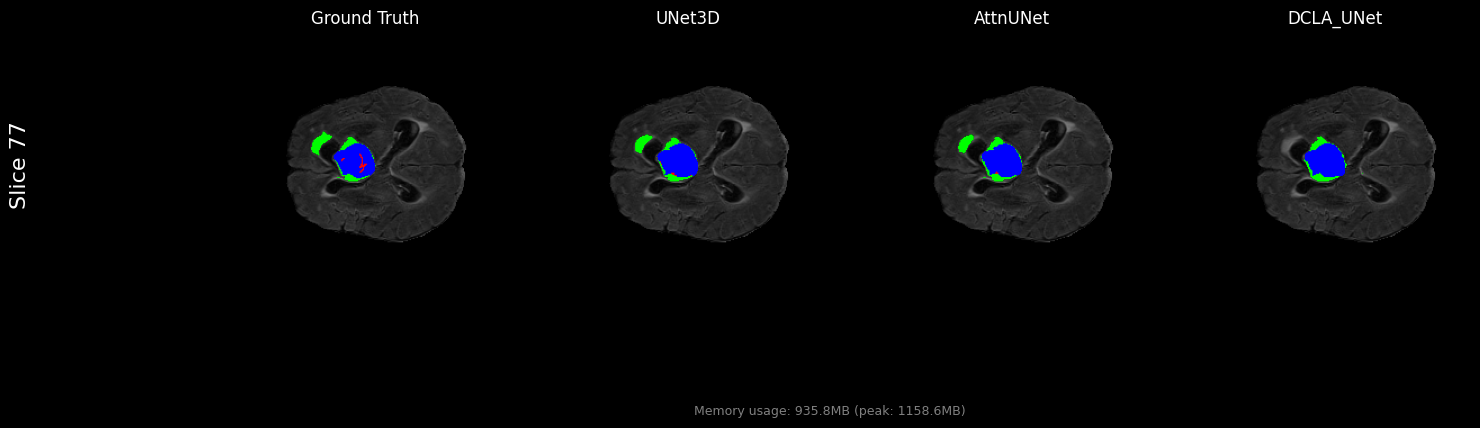

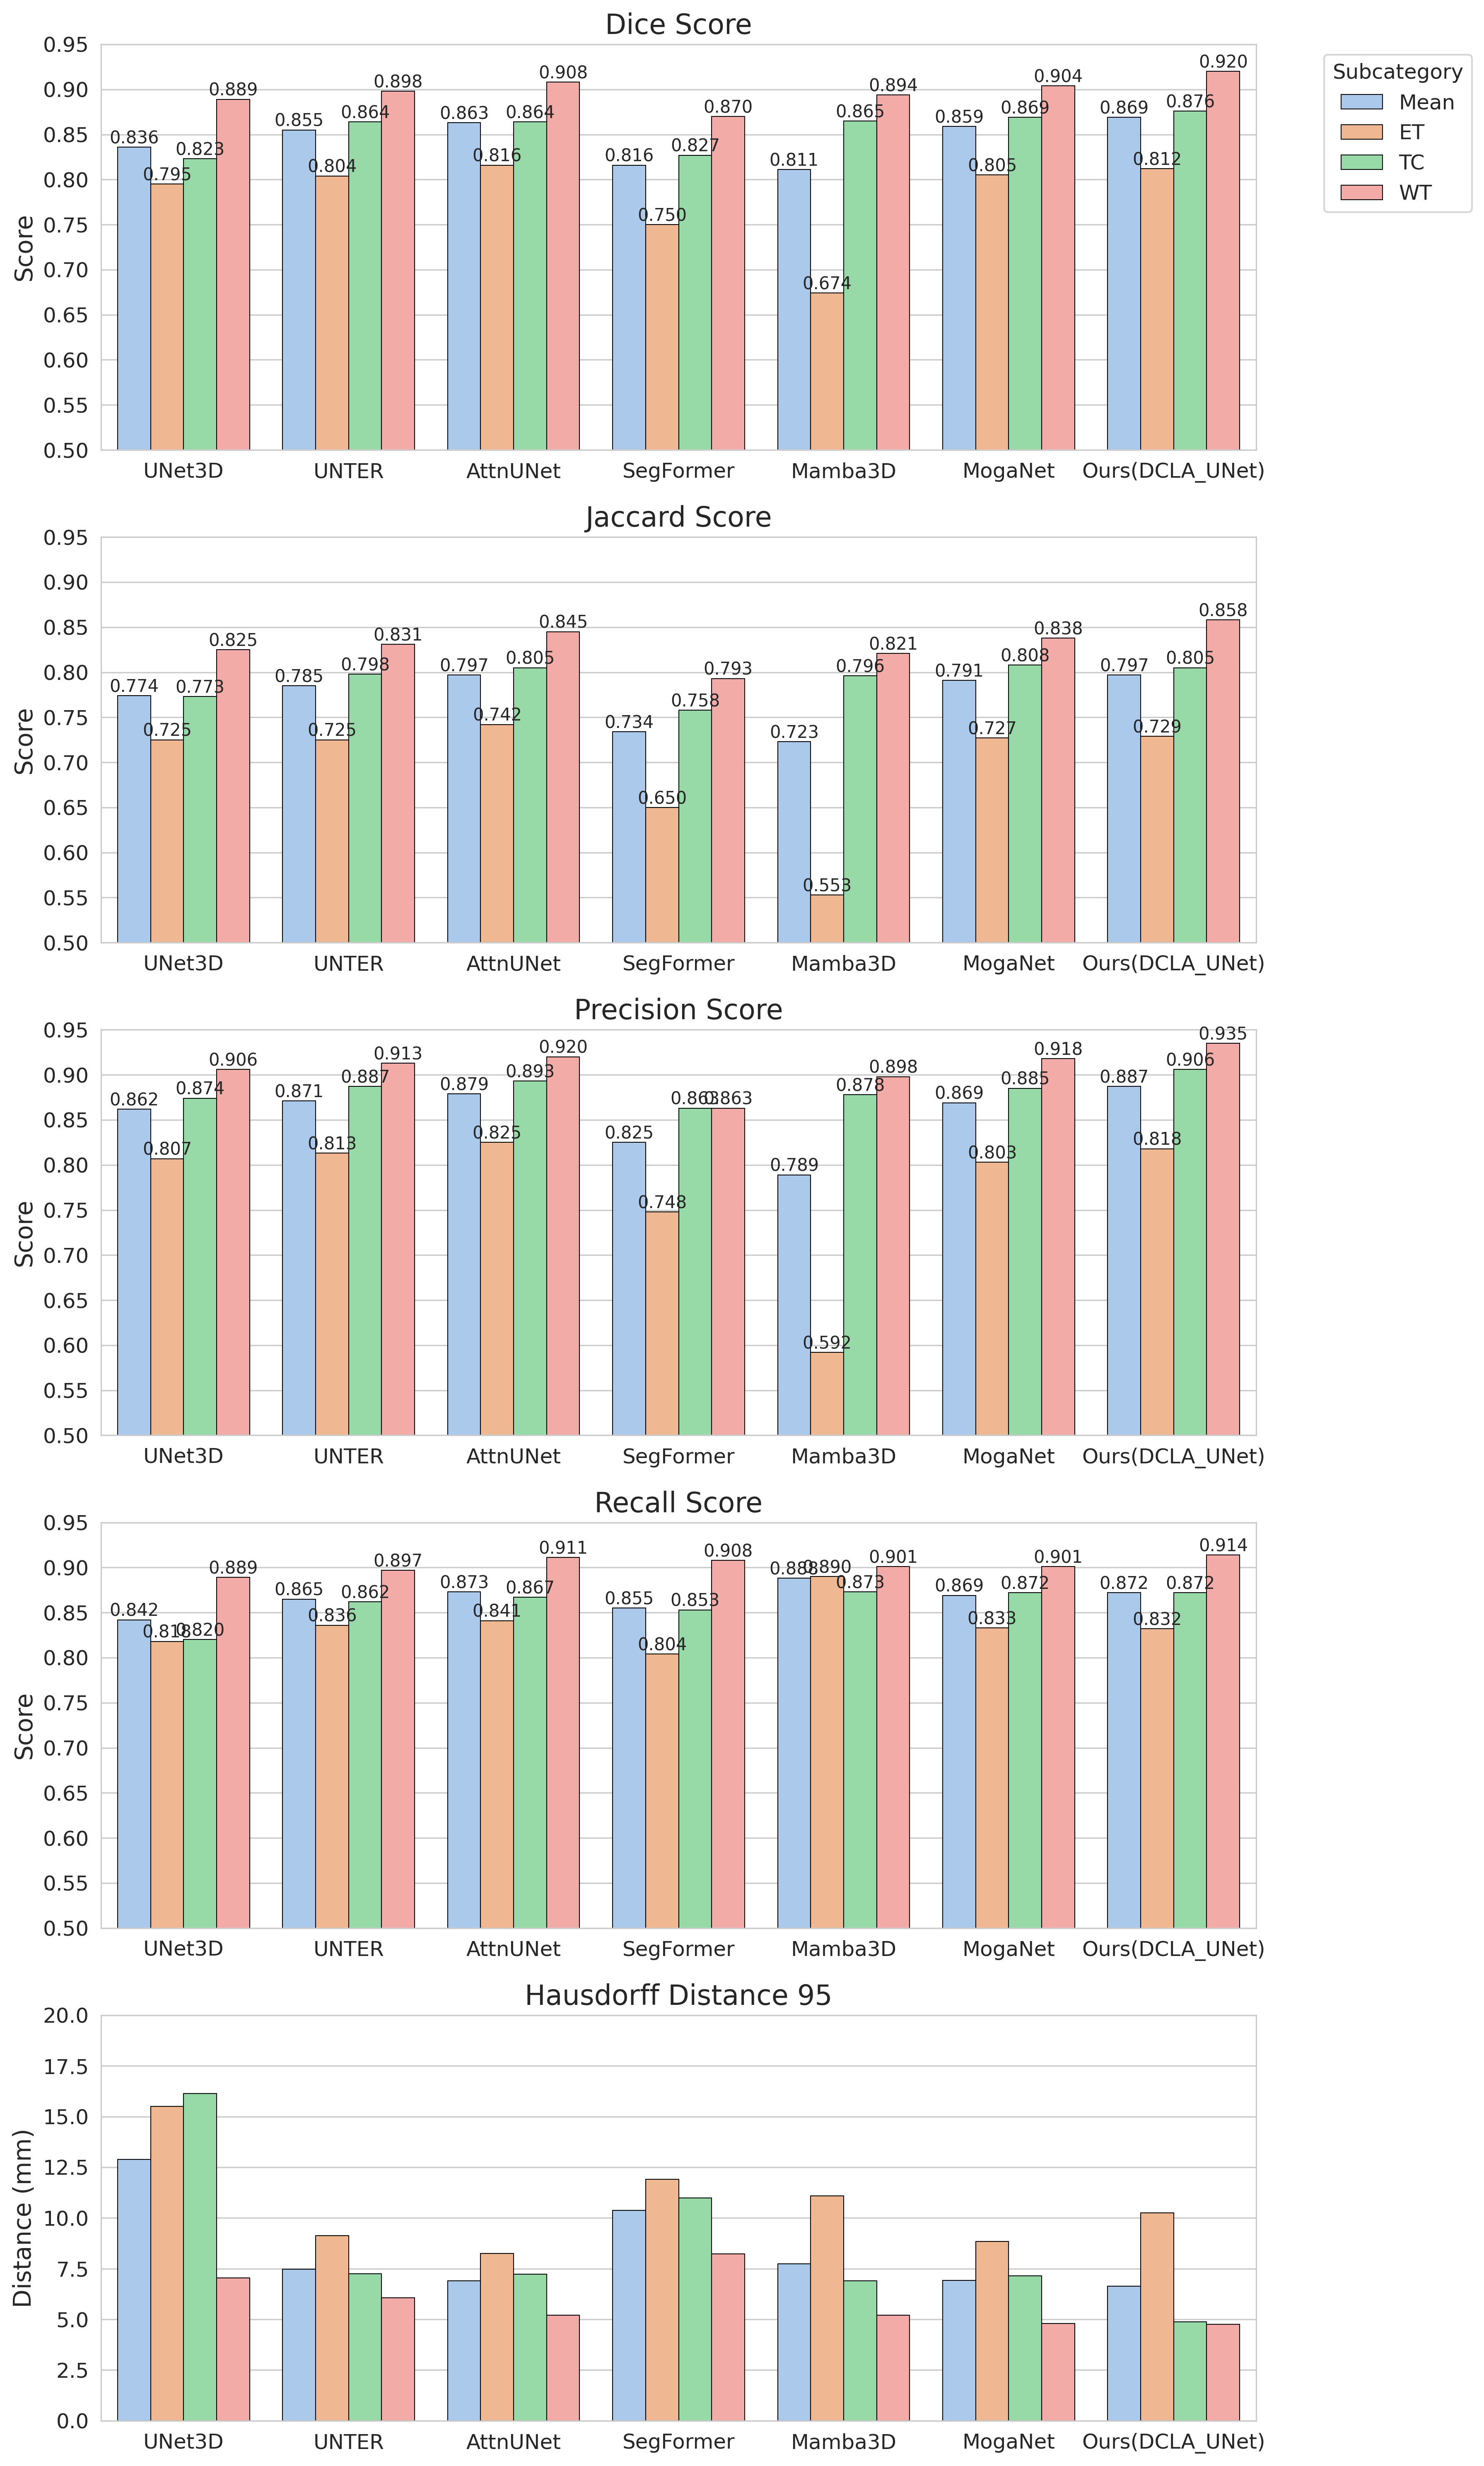

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 设置绘图样式
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})
sns.set_style("whitegrid")
# 创建数据框
data = [
    ["UNet3D", 0.836,0.795,0.823,0.889, 0.774,0.725,0.773,0.825, 0.862,0.807,0.874,0.906, 0.842,0.818,0.82,0.889, 12.888,15.492,16.134,7.038],
    ["UNTER", 0.855,0.804,0.864,0.898, 0.785,0.725,0.798,0.831, 0.871,0.813,0.887,0.913, 0.865,0.836,0.862,0.897, 7.483,9.128,7.257,6.065],
    ["AttnUNet", 0.863,0.816,0.864,0.908, 0.797,0.742,0.805,0.845, 0.879,0.825,0.893,0.92, 0.873,0.841,0.867,0.911, 6.895,8.252,7.223,5.209],
    ["SegFormer", 0.816,0.75,0.827,0.87, 0.734,0.65,0.758,0.793, 0.825,0.748,0.863,0.863, 0.855,0.804,0.853,0.908, 10.372,11.904,10.984,8.229],
    ["Mamba3D", 0.811,0.674,0.865,0.894, 0.723,0.553,0.796,0.821, 0.789,0.592,0.878,0.898, 0.888,0.89,0.873,0.901, 7.731,11.096,6.902,5.196],
    ["MogaNet", 0.859,0.805,0.869,0.904, 0.791,0.727,0.808,0.838, 0.869,0.803,0.885,0.918, 0.869,0.833,0.872,0.901, 6.927,8.834,7.151,4.795],
    ["Ours(DCLA_UNet)", 0.869,0.812,0.876,0.92, 0.797,0.729,0.805,0.858, 0.887,0.818,0.906,0.935, 0.872,0.832,0.872,0.914, 6.632,10.257,4.883,4.755]
]
columns = [
    "Models",
    *[f"Dice_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"Jaccard_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"Precision_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"Recall_{m}" for m in ["Mean","ET","TC","WT"]],
    *[f"HD95_{m}" for m in ["Mean","ET","TC","WT"]]
]
df = pd.DataFrame(data, columns=columns)
df = df.melt(id_vars="Models", var_name="Metric", value_name="Value")
df[["Metric", "Subcategory"]] = df["Metric"].str.split("_", expand=True)
# 定义绘图参数
metrics = ["Dice", "Jaccard", "Precision", "Recall", "HD95"]
palette = sns.color_palette("pastel", n_colors=4)
model_order = df.Models.unique()
# 创建子图
fig, axs = plt.subplots(5, 1, figsize=(12, 20), dpi=300)
plt.subplots_adjust(hspace=0.4)
# 为每个指标绘制图表
for idx, metric in enumerate(metrics):
    ax = axs[idx]
    mask = df.Metric == metric
    data = df[mask]
    sns.barplot(data=data, x="Models", y="Value", hue="Subcategory",
                palette=palette, ax=ax, order=model_order,
                edgecolor="black", linewidth=0.5)
    # 设置装饰参数
    ax.set_title(f"{metric} Score" if metric != "HD95" else "Hausdorff Distance 95")
    ax.set_xlabel("")
    ax.set_ylabel("Score" if metric != "HD95" else "Distance (mm)")
    ax.set_ylim((0.5, 0.95) if metric != "HD95" else (0, 20))
    # 添加数值标签
    if metric != "HD95":
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.3f}", 
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points',
                        fontsize=10)
    # 调整图例
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Subcategory", 
                 bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()
# 调整布局并保存
plt.tight_layout()
plt.savefig("model_comparison.png", bbox_inches='tight', dpi=300)
plt.show()
